In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import dateutil.parser
import datetime
from scipy.optimize import curve_fit
from scipy.stats import expon
import math
from dateutil import tz

In [4]:
df = pd.read_csv('../data/sorted_stations/Kampinmetroasema_sorted.csv', low_memory=False)

## Drop duplicated based on timestamp

In [5]:
df = df.drop_duplicates('ts').reset_index()

## Add some useful columns

In [6]:
# sort based on timestamp
df = df.sort_values('ts')
# the hour and minutes of the timestamp
df['hour_and_minutes'] = df['ts'].apply(lambda x: x[11:16])
# month of timestamp
df['month'] = df['ts'].apply(lambda x: x[5:7])
# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']
df['minutes_from_midnight'] = df['ts'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))
# df['hour'] = df['hour_and_minutes'].apply(lambda x: x[:2])
df['date'] = df.ts.apply(lambda x: pd.to_datetime(x, utc=True).astimezone(tz.tzlocal()))
df['hour'] = df.date.apply(lambda x: x.hour)
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['weekend'] = df['weekday'].apply(lambda x: x > 4)
df.head()

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,date,hour,weekday,weekend
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,04,0.0,765,2016-04-29 15:45:01+03:00,15,4,False
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,04,0.0,766,2016-04-29 15:46:01+03:00,15,4,False
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,04,0.0,768,2016-04-29 15:48:01+03:00,15,4,False
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,05,0.0,500,2016-05-01 11:20:01+03:00,11,6,True
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,05,0.0,501,2016-05-01 11:21:01+03:00,11,6,True


## Explore 

In [7]:
df.shape

(448054, 17)

In [8]:
df.describe()

,index,lat,lon,operative,bikes,total_slots,bikes_percent,minutes_from_midnight,hour,weekday
count,448054.000000,4.480540e+05,4.480540e+05,448054.0,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000
mean,224274.698300,6.016864e+01,2.493043e+01,1.0,4.798143,29.413651,0.167223,741.930807,12.436543,3.021613
std,129771.136239,1.407089e-10,1.234925e-11,0.0,4.918728,2.355847,0.175419,379.892851,6.607230,1.991776
min,0.000000,6.016864e+01,2.493043e+01,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,112013.250000,6.016864e+01,2.493043e+01,1.0,1.000000,28.000000,0.035714,430.000000,7.000000,1.000000
50%,224026.500000,6.016864e+01,2.493043e+01,1.0,3.000000,28.000000,0.107143,745.000000,13.000000,3.000000
75%,336039.750000,6.016864e+01,2.493043e+01,1.0,7.000000,33.000000,0.250000,1058.000000,18.000000,5.000000
max,462966.000000,6.016864e+01,2.493043e+01,1.0,33.000000,33.000000,1.178571,1439.000000,23.000000,6.000000


In [9]:
df.head(10)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,date,hour,weekday,weekend
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,04,0.0,765,2016-04-29 15:45:01+03:00,15,4,False
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,04,0.0,766,2016-04-29 15:46:01+03:00,15,4,False
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,04,0.0,768,2016-04-29 15:48:01+03:00,15,4,False
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,05,0.0,500,2016-05-01 11:20:01+03:00,11,6,True
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,05,0.0,501,2016-05-01 11:21:01+03:00,11,6,True
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,05,0.0,391,2016-05-02 09:31:01+03:00,9,0,False
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,05,0.0,392,2016-05-02 09:32:01+03:00,9,0,False
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,05,0.0,393,2016-05-02 09:33:01+03:00,9,0,False
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,05,0.0,396,2016-05-02 09:36:01+03:00,9,0,False
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,05,0.0,402,2016-05-02 09:42:01+03:00,9,0,False


In [10]:
by_hour = df.groupby('hour_and_minutes').mean()[0::60]
by_hour

,index,lat,lon,operative,bikes,total_slots,bikes_percent,minutes_from_midnight,hour,weekday,weekend
hour_and_minutes,,,,,,,,,,,
00:00,255989.825641,60.168644,24.930435,1.0,2.174359,29.871795,0.075602,0.0,2.994872,3.600000,0.446154
01:00,261231.364130,60.168644,24.930435,1.0,2.097826,29.956522,0.072776,60.0,4.005435,3.646739,0.451087
02:00,270803.115385,60.168644,24.930435,1.0,1.666667,30.275641,0.057130,120.0,5.006410,3.256410,0.365385
03:00,254976.460177,60.168644,24.930435,1.0,2.243363,29.783186,0.076983,180.0,5.995575,2.858407,0.252212
04:00,228373.466667,60.168644,24.930435,1.0,3.086667,29.500000,0.107352,240.0,6.993333,2.700000,0.200000
05:00,223809.227129,60.168644,24.930435,1.0,5.400631,29.388013,0.186786,300.0,7.990536,2.703470,0.205047
06:00,220349.478134,60.168644,24.930435,1.0,5.618076,29.341108,0.195219,360.0,8.973761,2.833819,0.236152
07:00,215768.711864,60.168644,24.930435,1.0,5.742938,29.299435,0.199541,420.0,9.977401,2.918079,0.262712
08:00,216747.935754,60.168644,24.930435,1.0,6.569832,29.298883,0.228893,480.0,10.980447,2.980447,0.284916


Text(0.5,1,'Bikes percentage each hour')

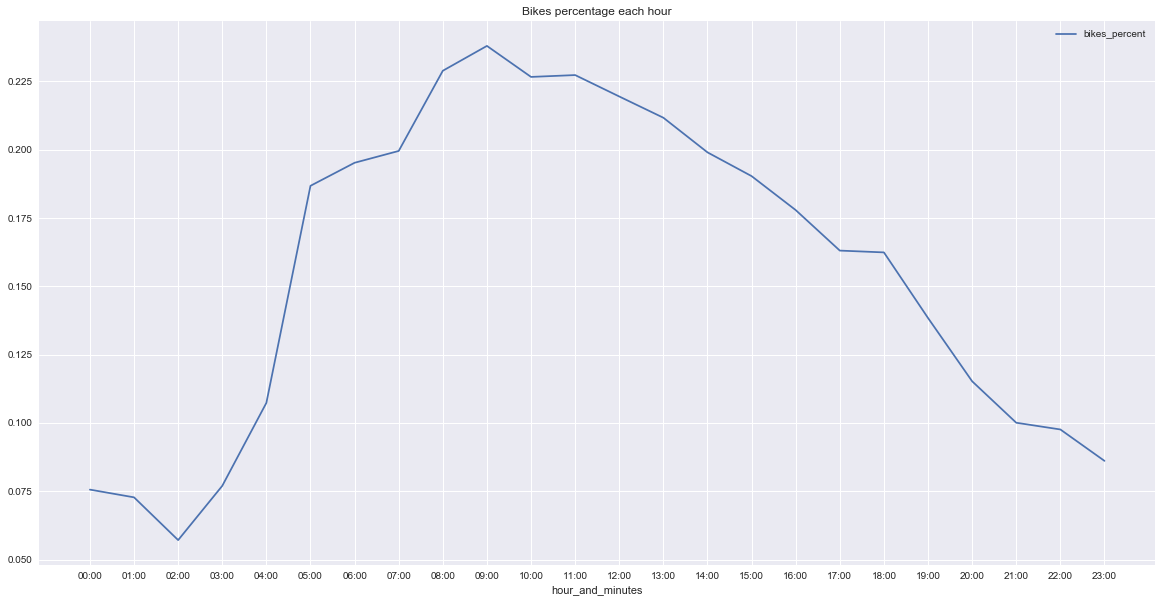

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
by_hour.plot(y='bikes_percent', ax=ax)
ax.set_xticks(range(len(by_hour.index)))
ax.set_xticklabels(by_hour.index)
plt.title('Bikes percentage each hour')

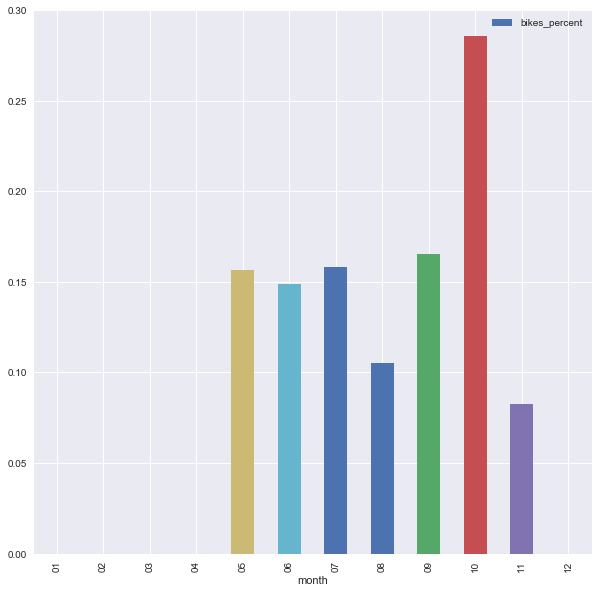

In [12]:
by_month = df.groupby('month').mean()
by_month.plot(y='bikes_percent', kind='bar', figsize=(10, 10))

## Prepare for predictions

### Add column which states whether a bike was added at a given moment

In [13]:
df['bike_added'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] < x['bikes'] , axis=1)
df['bike_removed'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] > x['bikes'] , axis=1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,date,hour,weekday,weekend,bike_added,bike_removed
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,04,0.000000,765,2016-04-29 15:45:01+03:00,15,4,False,False,False
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,04,0.000000,766,2016-04-29 15:46:01+03:00,15,4,False,False,False
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,04,0.000000,768,2016-04-29 15:48:01+03:00,15,4,False,False,False
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,05,0.000000,500,2016-05-01 11:20:01+03:00,11,6,True,False,False
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,05,0.000000,501,2016-05-01 11:21:01+03:00,11,6,True,False,False
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,05,0.000000,391,2016-05-02 09:31:01+03:00,9,0,False,False,False
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,05,0.000000,392,2016-05-02 09:32:01+03:00,9,0,False,False,False
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,05,0.000000,393,2016-05-02 09:33:01+03:00,9,0,False,False,False
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,05,0.000000,396,2016-05-02 09:36:01+03:00,9,0,False,False,False
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,05,0.000000,402,2016-05-02 09:42:01+03:00,9,0,False,False,False


## Initially waiting times were processed as dates and as minutes

## Eventually the date objects gave worse results

### Add max and running waiting time for next bike

In [14]:
# extract difference in minutes to a separate column
# on the moment that a bike was added, the waiting time is the time to next bike
i = 0
first_non_additive_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_added'] == False):
        i += 1
    if (i >= len(df)):
        break
    additive_row = df.iloc[i]
    time = additive_row['minutes_from_midnight']
    difference = abs(time - df.iloc[first_non_additive_index]['minutes_from_midnight'])
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike'] = difference 
    # add max wait as a date object
    date_time = additive_row['date']
    last_date = df.iloc[first_non_additive_index]['date']
    date_difference = abs((date_time - last_date).total_seconds() / 60)
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike_as_date'] = date_difference 
    # also add running waiting time as date (not max)
    date_times_until_now = df.loc[first_non_additive_index:i-1, 'date']
    date_difference_1 = abs((date_time - date_times_until_now).apply(lambda x: x.total_seconds() / 60))
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'wait_for_new_bike_as_date'] = date_difference_1 
    # add running time based on hour
    times_until_now = df.loc[first_non_additive_index:i-1, 'minutes_from_midnight']
    difference_1 = abs(time - times_until_now)
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'wait_for_new_bike'] = difference_1     
    first_non_additive_index = i
    i += 1
# if we can't know when the next bike will be added, fill with -1 for now
df = df.fillna(-1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,date,hour,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,...,2016-04-29 15:45:01+03:00,15,4,False,False,False,18.0,4302.0,4302.0,18.0
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,...,2016-04-29 15:46:01+03:00,15,4,False,False,False,18.0,4302.0,4301.0,19.0
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,...,2016-04-29 15:48:01+03:00,15,4,False,False,False,18.0,4302.0,4299.0,21.0
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,...,2016-05-01 11:20:01+03:00,11,6,True,False,False,18.0,4302.0,1687.0,247.0
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,...,2016-05-01 11:21:01+03:00,11,6,True,False,False,18.0,4302.0,1686.0,246.0
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,...,2016-05-02 09:31:01+03:00,9,0,False,False,False,18.0,4302.0,356.0,356.0
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,...,2016-05-02 09:32:01+03:00,9,0,False,False,False,18.0,4302.0,355.0,355.0
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,...,2016-05-02 09:33:01+03:00,9,0,False,False,False,18.0,4302.0,354.0,354.0
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,...,2016-05-02 09:36:01+03:00,9,0,False,False,False,18.0,4302.0,351.0,351.0
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,...,2016-05-02 09:42:01+03:00,9,0,False,False,False,18.0,4302.0,345.0,345.0


### Add idle time for each station

In [15]:
i = 0
idle_for = 0
idle_for_as_date = 0
while (i < len(df)):
    row = df.iloc[i]
    previous_row = df.iloc[(i-1 if i > 0 else 0)]
    if (not row['bikes'] == previous_row['bikes']):
        idle_for = 0
        idle_for_as_date = 0
        df.loc[i, 'idle_for'] = idle_for
        df.loc[i, 'idle_for_as_date'] = idle_for_as_date        
        i+= 1
        continue
    time_now = row['minutes_from_midnight']
    time_last = previous_row['minutes_from_midnight']
    date_time_now = row['date']
    date_time_last = previous_row['date']
    idle_for += abs(time_now - time_last)
    secs = (date_time_now - date_time_last).total_seconds()
    idle_for_as_date += abs(secs / 60)
    df.loc[i, 'idle_for'] = idle_for
    df.loc[i, 'idle_for_as_date'] = idle_for_as_date
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,idle_for,idle_for_as_date
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,...,4,False,False,False,18.0,4302.0,4302.0,18.0,0.0,0.0
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,...,4,False,False,False,18.0,4302.0,4301.0,19.0,1.0,1.0
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,...,4,False,False,False,18.0,4302.0,4299.0,21.0,3.0,3.0
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,...,6,True,False,False,18.0,4302.0,1687.0,247.0,271.0,2615.0
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,...,6,True,False,False,18.0,4302.0,1686.0,246.0,272.0,2616.0
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,...,0,False,False,False,18.0,4302.0,356.0,356.0,382.0,3946.0
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,...,0,False,False,False,18.0,4302.0,355.0,355.0,383.0,3947.0
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,...,0,False,False,False,18.0,4302.0,354.0,354.0,384.0,3948.0
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,...,0,False,False,False,18.0,4302.0,351.0,351.0,387.0,3951.0
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,...,0,False,False,False,18.0,4302.0,345.0,345.0,393.0,3957.0


In [16]:
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,idle_for,idle_for_as_date
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,...,4,False,False,False,18.0,4302.0,4302.0,18.0,0.0,0.0
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,...,4,False,False,False,18.0,4302.0,4301.0,19.0,1.0,1.0
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,...,4,False,False,False,18.0,4302.0,4299.0,21.0,3.0,3.0
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,...,6,True,False,False,18.0,4302.0,1687.0,247.0,271.0,2615.0
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,...,6,True,False,False,18.0,4302.0,1686.0,246.0,272.0,2616.0
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,...,0,False,False,False,18.0,4302.0,356.0,356.0,382.0,3946.0
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,...,0,False,False,False,18.0,4302.0,355.0,355.0,383.0,3947.0
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,...,0,False,False,False,18.0,4302.0,354.0,354.0,384.0,3948.0
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,...,0,False,False,False,18.0,4302.0,351.0,351.0,387.0,3951.0
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,...,0,False,False,False,18.0,4302.0,345.0,345.0,393.0,3957.0


In [17]:
df.describe()

,index,lat,lon,operative,bikes,total_slots,bikes_percent,minutes_from_midnight,hour,weekday,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,idle_for,idle_for_as_date
count,448054.000000,4.480540e+05,4.480540e+05,448054.0,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000,448054.000000
mean,224274.698300,6.016864e+01,2.493043e+01,1.0,4.798143,29.413651,0.167223,741.930807,12.436543,3.021613,133.419532,1071.753229,759.539414,72.408636,103.586490,290.605065
std,129771.136239,1.407089e-10,1.234925e-11,0.0,4.918728,2.355847,0.175419,379.892851,6.607230,1.991776,320.681501,16359.882043,13348.477940,243.503032,918.744193,7469.530074
min,0.000000,6.016864e+01,2.493043e+01,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,112013.250000,6.016864e+01,2.493043e+01,1.0,1.000000,28.000000,0.035714,430.000000,7.000000,1.000000,9.000000,9.000000,4.000000,4.000000,1.000000,1.000000
50%,224026.500000,6.016864e+01,2.493043e+01,1.0,3.000000,28.000000,0.107143,745.000000,13.000000,3.000000,20.000000,20.000000,9.000000,9.000000,4.000000,4.000000
75%,336039.750000,6.016864e+01,2.493043e+01,1.0,7.000000,33.000000,0.250000,1058.000000,18.000000,5.000000,55.000000,54.000000,25.000000,25.000000,13.000000,13.000000
max,462966.000000,6.016864e+01,2.493043e+01,1.0,33.000000,33.000000,1.178571,1439.000000,23.000000,6.000000,1435.000000,273799.000000,273799.000000,1439.000000,37672.000000,252304.000000


### Add time for next bike take

Predict how much time for the next bike to be taken: max waiting time is not useful here.

In [18]:
i = 0
first_non_removing_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_removed'] == False):
        i += 1
    if (i >= len(df)):
        break
    removing_row = df.iloc[i]
    time = removing_row['minutes_from_midnight']
    times_until_now = df.loc[first_non_removing_index:i-1, 'minutes_from_midnight']
    difference = abs(time - times_until_now)
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken'] = difference 
    date_time = removing_row['date']
    date_times_until_now = df.loc[first_non_removing_index:i-1, 'date']
    date_difference = abs((date_time - date_times_until_now).apply(lambda x: x.total_seconds() / 60))
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken_as_date'] = date_difference 
    first_non_removing_index = i
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,idle_for,idle_for_as_date,wait_for_bike_taken,wait_for_bike_taken_as_date
0,0,2016-04-29T12:45:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:45,...,False,False,18.0,4302.0,4302.0,18.0,0.0,0.0,2.0,4322.0
1,1,2016-04-29T12:46:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:46,...,False,False,18.0,4302.0,4301.0,19.0,1.0,1.0,1.0,4321.0
2,2,2016-04-29T12:48:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,12:48,...,False,False,18.0,4302.0,4299.0,21.0,3.0,3.0,1.0,4319.0
3,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,...,False,False,18.0,4302.0,1687.0,247.0,271.0,2615.0,267.0,1707.0
4,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,...,False,False,18.0,4302.0,1686.0,246.0,272.0,2616.0,266.0,1706.0
5,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,...,False,False,18.0,4302.0,356.0,356.0,382.0,3946.0,376.0,376.0
6,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,...,False,False,18.0,4302.0,355.0,355.0,383.0,3947.0,375.0,375.0
7,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,...,False,False,18.0,4302.0,354.0,354.0,384.0,3948.0,374.0,374.0
8,8,2016-05-02T06:36:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:36,...,False,False,18.0,4302.0,351.0,351.0,387.0,3951.0,371.0,371.0
9,9,2016-05-02T06:42:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:42,...,False,False,18.0,4302.0,345.0,345.0,393.0,3957.0,365.0,365.0


### Add weather data

In [19]:
weather = pd.read_csv('../data/weather_all.csv')
weather.head()

,Year,m,d,Time,Time zone,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,2016,5,1,00:00,UTC,1.0,1027.1,85.0,0.0,5.8,3.5,50000.0,276.0,4.1,3.7
1,2016,5,1,01:00,UTC,3.0,1027.2,82.0,0.0,6.2,3.3,50000.0,280.0,4.4,3.7
2,2016,5,1,02:00,UTC,0.0,1027.3,82.0,0.0,5.8,2.9,50000.0,279.0,4.3,3.9
3,2016,5,1,03:00,UTC,0.0,1027.4,82.0,0.0,5.7,2.9,47870.0,259.0,3.0,2.2
4,2016,5,1,04:00,UTC,0.0,1027.6,78.0,0.0,7.0,3.3,45900.0,277.0,3.0,2.0


In [20]:
# fill missing values with the last known value
weather = weather.fillna(method="pad")

In [21]:
weather['merge_timestamp'] = weather.apply(lambda x: '%s/%s/%s %s' % (x['Year'], x['m'], x['d'], x['Time']), axis=1)

In [22]:
df['merge_timestamp'] = df.apply(lambda x: '%s/%s/%s %s' % (x['date'].year, x['date'].month, x['date'].day, x['date'].strftime('%H:00')), axis=1)

In [23]:
df = pd.merge(df, weather, on='merge_timestamp')

In [24]:
df = df.drop(columns=['Year', 'm', 'd', 'Time', 'Time zone', 'merge_timestamp'])

In [25]:
df.columns.values

array(['index', 'ts', 'lat', 'lon', 'operative', 'sid', 'name', 'bikes',
       'total_slots', 'hour_and_minutes', 'month', 'bikes_percent',
       'minutes_from_midnight', 'date', 'hour', 'weekday', 'weekend',
       'bike_added', 'bike_removed', 'max_wait_for_new_bike',
       'max_wait_for_new_bike_as_date', 'wait_for_new_bike_as_date',
       'wait_for_new_bike', 'idle_for', 'idle_for_as_date',
       'wait_for_bike_taken', 'wait_for_bike_taken_as_date',
       'Cloud amount (1/8)', 'Pressure (msl) (hPa)',
       'Relative humidity (%)', 'Precipitation intensity (mm/h)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Horizontal visibility (m)', 'Wind direction (deg)',
       'Gust speed (m/s)', 'Wind speed (m/s)'], dtype=object)

In [26]:
df.shape

(448051, 37)

In [27]:
df.head()

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,3,2016-05-01T08:20:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:20,...,0.0,1027.2,39.0,0.0,15.1,1.4,37690.0,187.0,8.6,6.0
1,4,2016-05-01T08:21:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,08:21,...,0.0,1027.2,39.0,0.0,15.1,1.4,37690.0,187.0,8.6,6.0
2,5,2016-05-02T06:31:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:31,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
3,6,2016-05-02T06:32:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:32,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
4,7,2016-05-02T06:33:01,60.168644,24.930435,1,A30,Kampin metroasema,0,28,06:33,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1


## Plot division of max waiting time for new bike

### Sorted by frequency

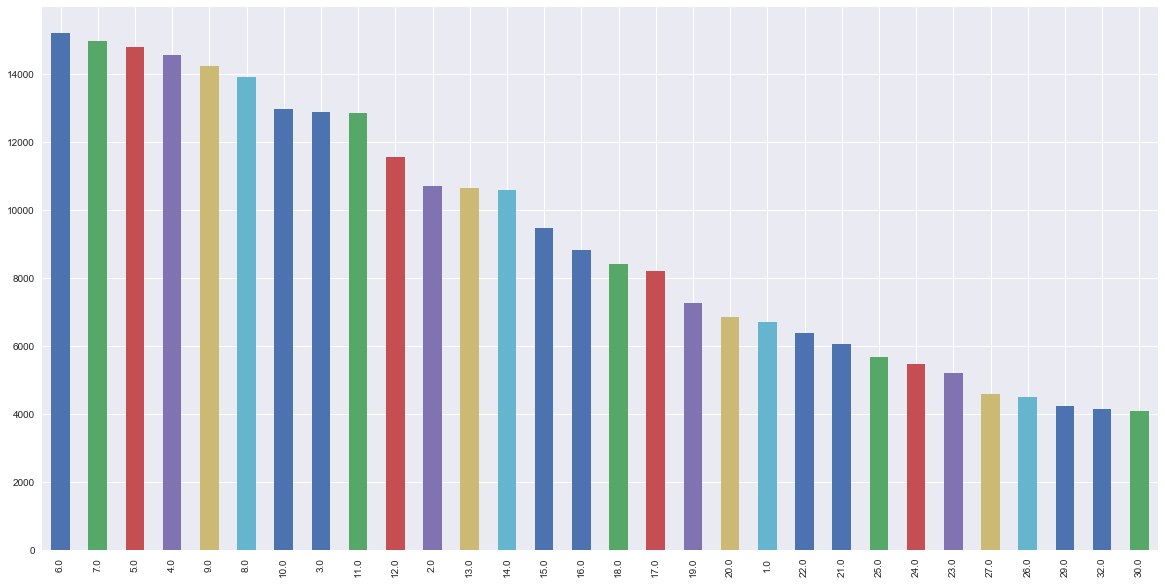

In [28]:
# sort by frequency
by_max_wait = df['max_wait_for_new_bike'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_max_wait.plot(kind='bar', figsize=(20, 10))

### Sorted by waiting time

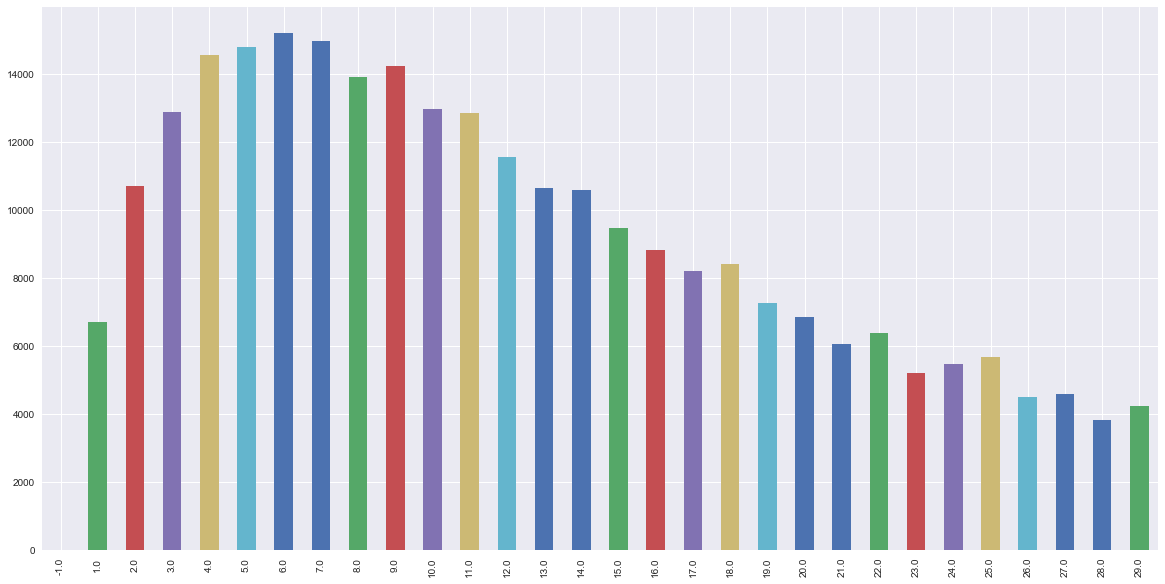

In [29]:
# sort by waiting time
by_max_wait_count = df['max_wait_for_new_bike'].value_counts()
by_max_wait_sorted = by_max_wait_count.sort_index().head(30)
by_max_wait_normalized = by_max_wait_sorted.index
by_max_wait_sorted.plot(kind='bar', figsize=(20, 10))

### Normalized waiting time

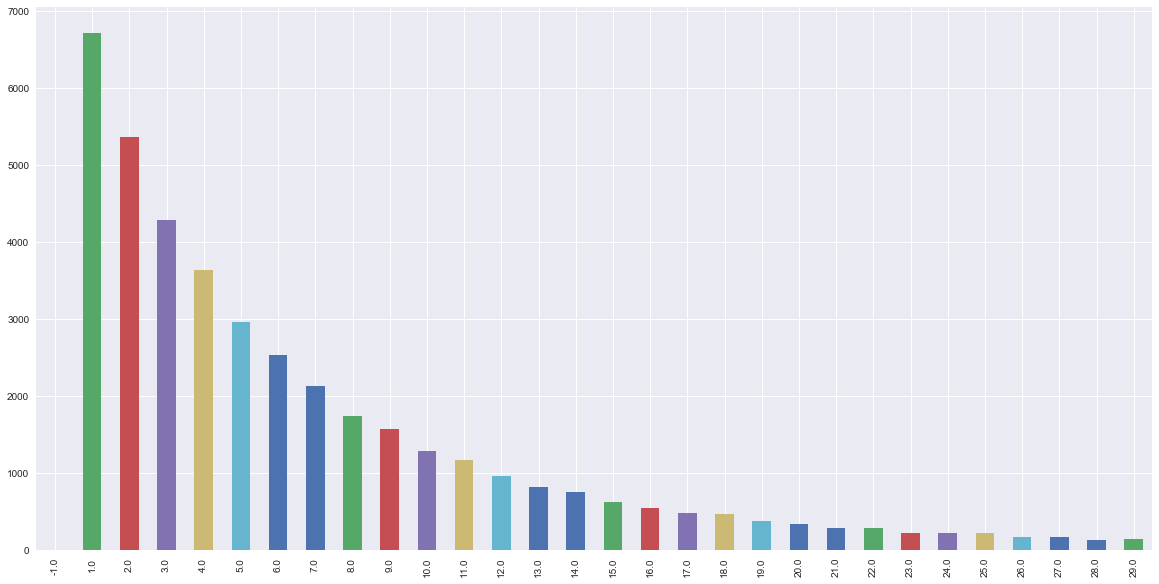

In [30]:
# normalize by dividing by key in order not to emphasize big values
by_max_wait_normalized = abs(by_max_wait_sorted / by_max_wait_sorted.index)
by_max_wait_normalized.plot(kind='bar', figsize=(20, 10))

## Plot distribution of wait for next taken bike

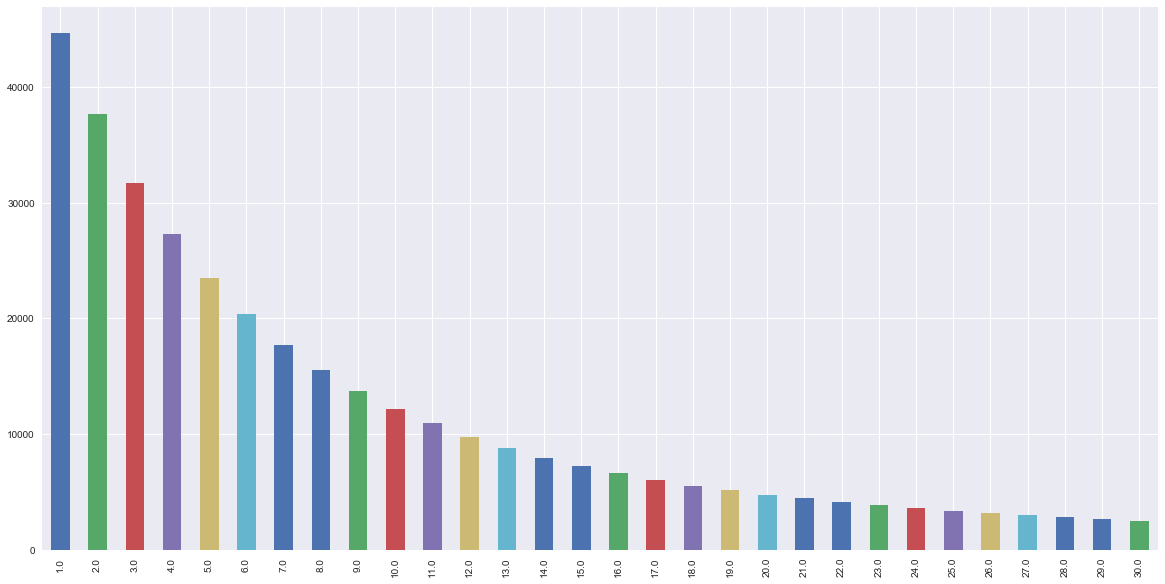

In [31]:
# sort by frequency
by_take_wait = df['wait_for_bike_taken'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Plot distribution of idle time

In [32]:
# sort by frequency
# by_take_wait = df['idle_for'].value_counts(ascending=True).sort_values(ascending=False).head(30)
# by_take_wait.plot(kind='bar', figsize=(20, 10))

## Build linear regression models

### Remove useless or codependent columns

In [33]:
max_wait_counts = df['max_wait_for_new_bike_as_date'].value_counts()
wait_counts = df['wait_for_bike_taken_as_date'].value_counts()

In [34]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
# remove outliers = if theres less than 10 data points of a specific waiting time
filterable_max_waits = max_wait_counts[max_wait_counts < 10].index
filterable_waits = wait_counts[wait_counts < 10].index
cleaned_df = cleaned_df[~cleaned_df['max_wait_for_new_bike_as_date'].isin(filterable_max_waits)]
cleaned_df = cleaned_df[~cleaned_df['wait_for_bike_taken_as_date'].isin(filterable_waits)]
print('removed', len(df) - len(cleaned_df), 'rows')

removed 4482 rows


In [35]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
cleaned_df.head(20)

,operative,month,bikes_percent,hour,weekday,weekend,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,...,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,1,05,0.0,11,6,True,18.0,4302.0,1687.0,247.0,...,0.0,1027.2,39.0,0.0,15.1,1.4,37690.0,187.0,8.6,6.0
1,1,05,0.0,11,6,True,18.0,4302.0,1686.0,246.0,...,0.0,1027.2,39.0,0.0,15.1,1.4,37690.0,187.0,8.6,6.0
2,1,05,0.0,9,0,False,18.0,4302.0,356.0,356.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
3,1,05,0.0,9,0,False,18.0,4302.0,355.0,355.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
4,1,05,0.0,9,0,False,18.0,4302.0,354.0,354.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
5,1,05,0.0,9,0,False,18.0,4302.0,351.0,351.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
6,1,05,0.0,9,0,False,18.0,4302.0,345.0,345.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
7,1,05,0.0,9,0,False,18.0,4302.0,344.0,344.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
8,1,05,0.0,9,0,False,18.0,4302.0,342.0,342.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1
9,1,05,0.0,9,0,False,18.0,4302.0,335.0,335.0,...,0.0,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1


### Predict when the next bike will be brought

### Max wait

In [36]:
# remove the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_new_bike_as_date', 'wait_for_new_bike', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, wait_for_new_bike, idle_for, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.3750698307672127

### Accurate wait

In [37]:
# remove the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, wait_for_new_bike, idle_for, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.07377965486658788

### Predict when the next bike will be taken

In [38]:
# remove the column to predict
x = cleaned_df.drop(columns=['wait_for_bike_taken', 'max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken_as_date', 'wait_for_new_bike_as_date'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, wait_for_new_bike, idle_for, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.0796866841165853

### Predict the percentage of bikes at the station

In [39]:
# remove the column to predict
x = cleaned_df.drop(columns=['bikes_percent'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['bikes_percent']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, hour, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, wait_for_new_bike_as_date, wait_for_new_bike, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.13150343302892054

### Predict the hour based on amount of bikes at station

In [40]:
# remove the column to predict
x = cleaned_df.drop(columns=['hour'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['hour']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, wait_for_new_bike_as_date, wait_for_new_bike, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.2235684145459944

## Evaluate the model manually 

### Max waiting time for new bike

In [41]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'wait_for_new_bike_as_date'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on operative, month, bikes_percent, hour, weekday, weekend, wait_for_new_bike, idle_for, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
test dataset length:  89611
percentages of predictions within 1 mins of target: 0.000502170492461863
percentages of predictions within 2 mins of target: 0.0009820222963698652
percentages of predictions within 3 mins of target: 0.0014618741002778678
percentages of predictions within 4 mins of target: 0.0018970885270781488
percentages of predictions within 5 mins of target: 0.0025443304951401056
percentages of predictions within 6 mins of target: 0.0029795449219403866
percentages of predictions within 7 mins of target: 0.0034482373815714587
percentages of predictions within 8 mins of target: 0.0038946111526486703
percentages of predict

### Waiting time for next bike taken

In [42]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
x_train
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on operative, month, bikes_percent, hour, weekday, weekend, wait_for_new_bike_as_date, wait_for_new_bike, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
test dataset length:  89611
percentages of predictions within 1 mins of target: 0.0025778085279708966
percentages of predictions within 2 mins of target: 0.005010545580341699
percentages of predictions within 3 mins of target: 0.007398645255604781
percentages of predictions within 4 mins of target: 0.010054569193514188
percentages of predictions within 5 mins of target: 0.012476146901608061
percentages of predictions within 6 mins of target: 0.01512091149524054
percentages of predictions within 7 mins of target: 0.018100456417180926
percentages of predictions within 8 mins of target: 0.020633627568044103
percentages 

# Use exponential distribution as baseline and fit weather data to linear model

## Build distribution for weekday and hour

In [46]:
def build_hourly_distribution_by_weekday(rows):
    distribution = []
    prev = None
    count = 0
    for idx, cur in rows:
        if prev is None:
            count += 1
        elif (cur.date - prev.date).total_seconds() > 120:
            count = 0
        elif prev.bikes >= cur.bikes:
            count += 1
        else:
            distribution.append((cur.weekday, cur.hour, count + 1))
            count = 0
        prev = cur
    return distribution
hourly_distribution_by_weekday = build_hourly_distribution_by_weekday(df.iterrows())

## Merge built distribution with other data

In [54]:
labels = ['weekday', 'hour', 'estimated_hour_wait_time']
df_wait_times = pd.DataFrame.from_records(hourly_distribution_by_weekday, columns=labels)

In [55]:
grouped_waits = df_wait_times.groupby(by=['weekday', 'hour']).estimated_hour_wait_time.value_counts(sort=False)
grouped_waits.head()

weekday  hour  estimated_hour_wait_time
0        0     1                           7
               2                           2
               4                           1
               5                           3
               6                           4
Name: estimated_hour_wait_time, dtype: int64

## Fit exponential distribution for each day and hour

In [56]:
def expfunc(x, l):
    return l * math.e ** (-l * x)
def get_estimate(scale):
    return expon.ppf(0.75, scale=1/scale)
def learn_parameter(waits):
    return curve_fit(expfunc, waits.keys(), waits.values, p0=0)

In [57]:
estimates = []
rain_limit = 0.5
temp_limit = 20
weekdays = ['Monday', 'Tuesday', 'Wednesdy', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in range(7):
    for hour in range(24):
        curr_data = cleaned_df[(cleaned_df.weekday == weekday) & (cleaned_df.hour == hour)]
        waits = curr_data.wait_for_new_bike.value_counts(normalize=True).sort_index()
        # according to temperature
        cold = curr_data[curr_data['Air temperature (degC)'] < temp_limit]
        cold_waits = cold.wait_for_new_bike.value_counts(normalize=True).sort_index()
        warm = curr_data[curr_data['Air temperature (degC)'] >= temp_limit]
        warm_waits = warm.wait_for_new_bike.value_counts(normalize=True).sort_index()
        # according to amount of rain
        no_rain = curr_data[curr_data['Precipitation intensity (mm/h)'] <  rain_limit]
        with_rain = curr_data[curr_data['Precipitation intensity (mm/h)'] >=   rain_limit]
        no_rain_waits = no_rain.wait_for_new_bike.value_counts(normalize=True).sort_index()
        rain_waits = with_rain.wait_for_new_bike.value_counts(normalize=True).sort_index()
        if len(waits.values) == 0 or len(rain_waits.values) == 0 or len(warm.values) == 0:
            continue
        # fit exponential distribution to curve
        popt, _ = learn_parameter(waits)
        rain_popt, _ = learn_parameter(rain_waits)
        warm_popt, _ = learn_parameter(warm_waits)
        # get estimates
        all_estimate = get_estimate(popt[0])
        rain_estimate = get_estimate(rain_popt[0])
        warm_estimate = get_estimate(warm_popt[0])     
        estimate = get_estimate(popt[0])
        # build estimation dictionary
        estimates.append({
            'weekday': weekday, 
            'hour': hour, 
            'estimate': estimate, 
            'rain_estimate': rain_estimate, 
            'warm_estimate': warm_estimate, 
            'label': weekdays[weekday],
            'waits': waits,
            'no_rain_waits': no_rain_waits,
            'rain_waits': rain_waits,
            'cold_waits': cold_waits,
            'warm_waits': warm_waits
        })
len(estimates)

/home/nikkaire/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


145

## Make estimates into dataframe

In [58]:
labels = ['weekday', 'hour', 'estimated_hour_wait_time']
estimates_df = pd.DataFrame.from_records(estimates, columns=labels)
merged_df = pd.merge(cleaned_df, estimates_df, on=['hour', 'weekday'])
merged_df.head()

,operative,month,bikes_percent,hour,weekday,weekend,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,wait_for_new_bike,...,Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),estimated_hour_wait_time
0,1,05,0.0,9,0,False,18.0,4302.0,356.0,356.0,...,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1,NaN
1,1,05,0.0,9,0,False,18.0,4302.0,355.0,355.0,...,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1,NaN
2,1,05,0.0,9,0,False,18.0,4302.0,354.0,354.0,...,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1,NaN
3,1,05,0.0,9,0,False,18.0,4302.0,351.0,351.0,...,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1,NaN
4,1,05,0.0,9,0,False,18.0,4302.0,345.0,345.0,...,1025.7,32.0,0.0,15.4,-1.3,30680.0,201.0,6.2,4.1,NaN


## Fit weather data to exponential estimate

In [52]:
x = merged_df[['estimated_hour_wait_time', 'Precipitation intensity (mm/h)', 'Air temperature (degC)', 'Wind speed (m/s)']]
print('predicting based on', ', '.join(x.columns.values))
y = merged_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:', model.score(x_test, y_test))
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on estimated_hour_wait_time, Precipitation intensity (mm/h), Air temperature (degC), Wind speed (m/s)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').